In [1]:
import os
import numpy
import matplotlib.pyplot as plt

In [2]:
try:
    from PIL import Image, ImageDraw, ImageFont

    # name of the file to save
    filename = "img01.png"
    #fnt = ImageFont.truetype('arial.ttf', 15)
    fontsize=50
    fnt = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf',fontsize)
    # create new image
    image = Image.new(mode = "RGB", size = (230,70), color = "white")
    draw = ImageDraw.Draw(image)
    draw.text((10,10), "SpatialPy", font=fnt, fill=(0,0,0))

    image_array = numpy.asarray(image)
    if not os.path.isfile('image.pkl'):
        import pickle
        with open('image.pkl','wb') as p:
            pickle.dump(image_array,p)

except ModuleNotFoundError:
    import pickle
    with open('image.pkl','rb') as p:
        image_array = pickle.load(p)


In [3]:
image

NameError: name 'image' is not defined

In [4]:
image_array.shape

(70, 230, 3)

In [7]:
#!rm image.pkl
!ls -l

total 3440
-rw-rw-r-- 1 brian brian 1938782 Jul  1 14:16 BoundaryCondition.ipynb
-rw-rw-r-- 1 brian brian   48456 Jul  1 17:21 image.pkl
-rw-rw-r-- 1 brian brian 1530663 Jul  1 17:05 Spatialpy_gravity.ipynb


(2.8999999999999986, 225.1, 9.85, 57.15)

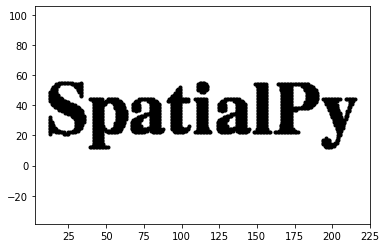

In [5]:
word_points_x = []
word_points_y = []
#print("image_array.shape",image_array.shape)
for y in range(image_array.shape[0]):
    for x in range(image_array.shape[1]):
        if image_array[y,x,0] < 50:
            word_points_x.append(x)
            word_points_y.append(-y + image_array.shape[0])
#print('word_points_x',len(word_points_x))
#print('word_points_y',len(word_points_y))
plt.plot(word_points_x, word_points_y,'.k')
plt.axis('equal')

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.insert(0,'../..')
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [8]:
class HardFloor(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[1] < system->ylo){
            me->x[1] = system->ylo;
            me->v[1] = 0.0;
        }
        """

In [44]:
class BouncyFloor(spatialpy.BoundaryCondition):
    def expression(self):
        return """
        if(me->x[1] < system->ylo){
            me->x[1] = system->ylo;
            me->v[1] = -0.9 * me->v[1];
        }
        """

In [45]:
class SpatialPyGravity(spatialpy.Model):
    def __init__(self,x_vals,y_vals, xmax, ymax):
        spatialpy.Model.__init__(self,"SpatialPyGravity")
        self.mesh = spatialpy.Mesh(len(x_vals), 
                        (0,xmax), (0,ymax), (0,0),
                        gravity=[0,-1,0])
        for i in range(len(x_vals)):
            self.mesh.vertices[i,0] = x_vals[i]
            self.mesh.vertices[i,1] = y_vals[i]
            self.mesh.sd[i] = 1
            self.mesh.mass[i] = 1.0
            self.mesh.vol[i] = 1.0
            self.mesh.nu[i] = 1.0

        # Define time parameters
        self.timestep_size = 1e-2  # timestep size
        self.num_timesteps = 2000    # number of timesteps
        self.output_freq = 100      # frequency of outputting results

        self.staticDomain = False
        
        #self.add_boundary_condition(HardFloor())
        self.add_boundary_condition(BouncyFloor())


In [46]:
model = SpatialPyGravity(word_points_x,word_points_y,
                 image_array.shape[1],image_array.shape[0])

In [47]:
sol = spatialpy.Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 59.3 s, sys: 1.11 s, total: 1min
Wall time: 1min 3s


In [48]:
%time result = sol.run()

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 2min 49s


In [59]:
result.plot_property('type')

In [50]:
# Plot_step access the result object and search for the specified key to plot
def plot_step(time=0,key='type',index=0):
    try:
        pts, data = result.read_step(time)
    except Exception:
        print("error reading time={0}".format(time))
        return
    plt.figure(figsize=(15,10) )       
    if (key == 'v'):
        d = data[key]
        d = [d[i][index] for i in range(0,len(d))]
    else:
        d = data[key]
    plt.scatter(pts[:,0],pts[:,1],c=d)
    plt.axis('scaled')
    #plt.colorbar()
    plt.title('t={0}'.format(time*model.timestep_size*model.output_freq))
    #plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
    #plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
    plt.grid(linestyle='--', linewidth=1)
    plt.xlim(result.model.mesh.xlim)
    plt.ylim(result.model.mesh.ylim)
    
    
    
def plot_all(key='type',index=0):
    for i,t in enumerate(result.get_timespan()):
        plot_step(i,key,index)

(0.0, 70.0)

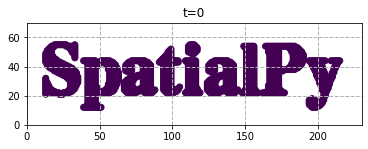

In [51]:
pts, data = result.read_step(0)
plt.scatter(pts[:,0],pts[:,1],c=data['type'])
plt.axis('scaled')
#plt.colorbar()
plt.title('t={0}'.format(0))
#plt.xticks(numpy.arange(-0.6, 0.7, 0.1)) 
#plt.yticks(numpy.arange(-0.6, 0.7, 0.1)) 
plt.grid(linestyle='--', linewidth=1)
plt.xlim(result.model.mesh.xlim)
plt.ylim(result.model.mesh.ylim)

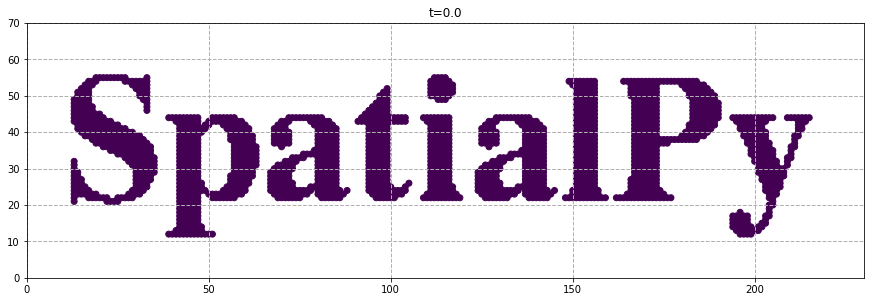

In [52]:
plot_step(0)

error reading time=13
error reading time=14
error reading time=15
error reading time=16
error reading time=17
error reading time=18
error reading time=19
error reading time=20


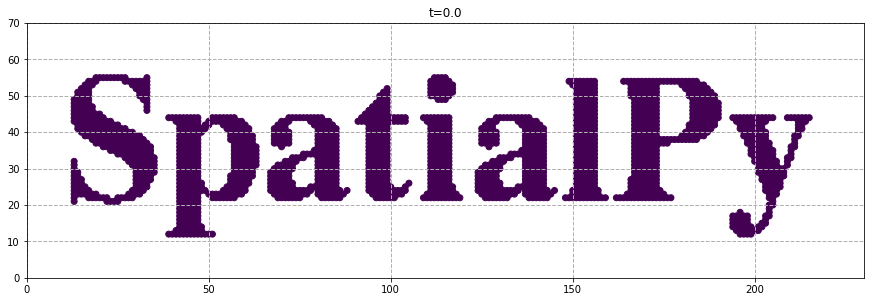

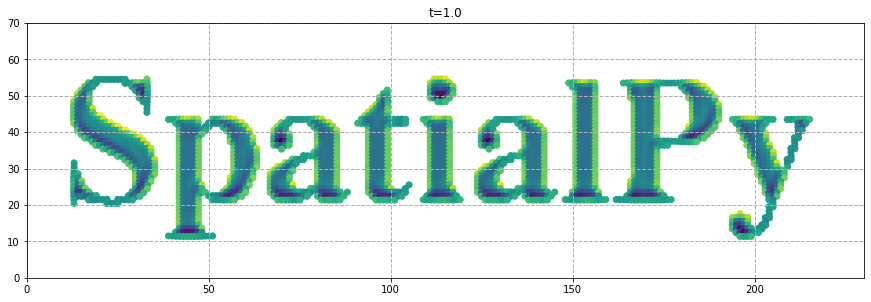

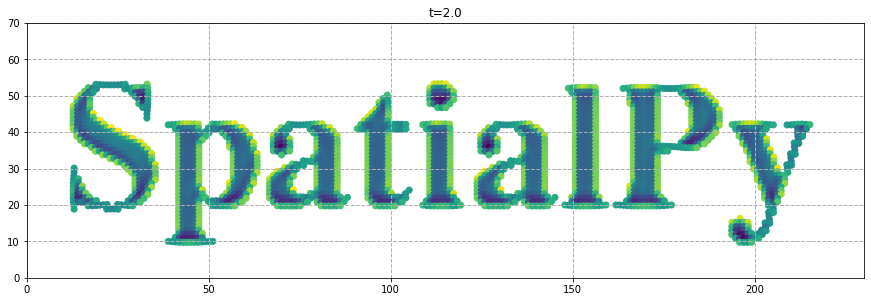

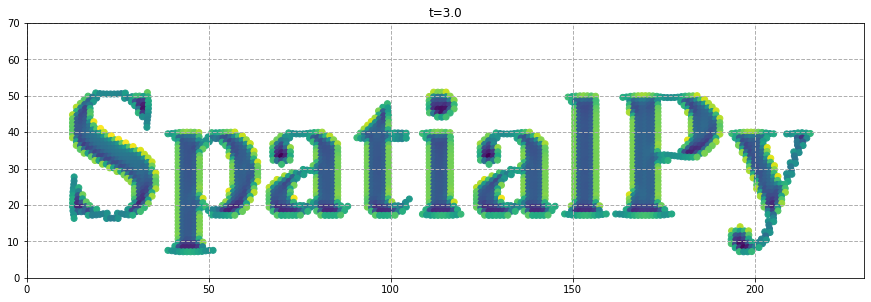

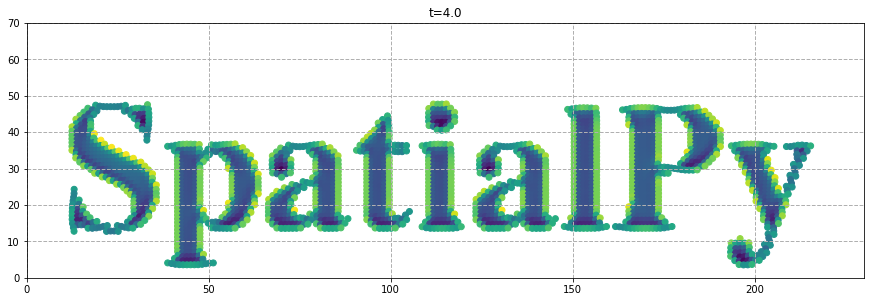

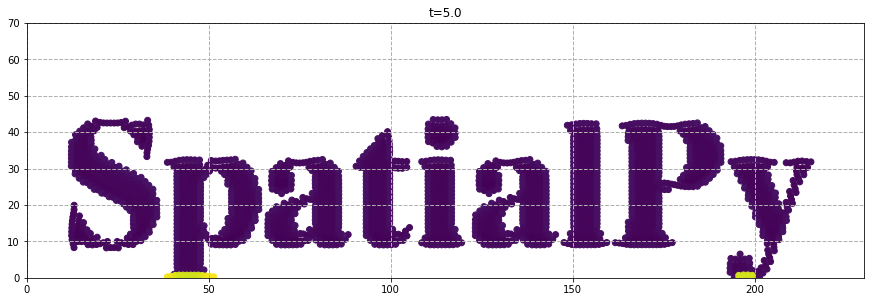

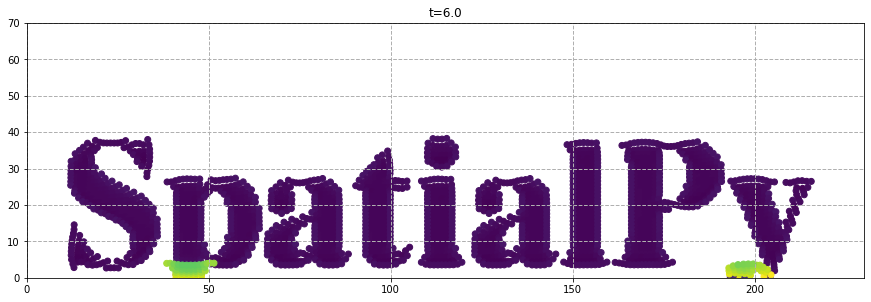

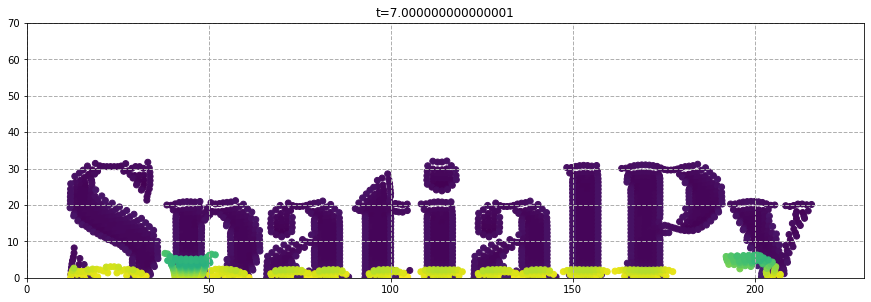

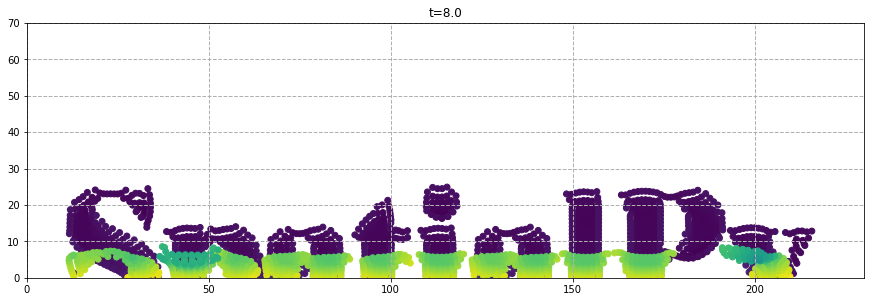

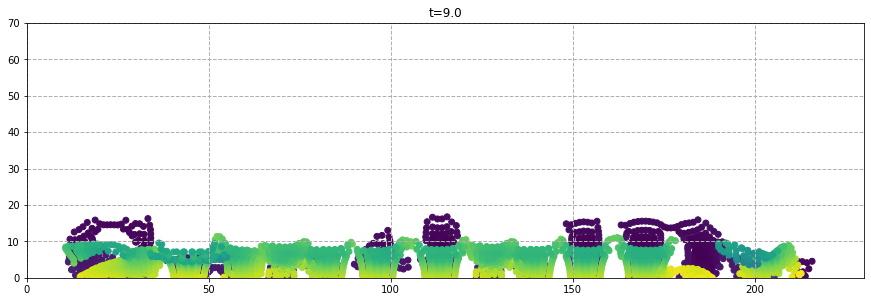

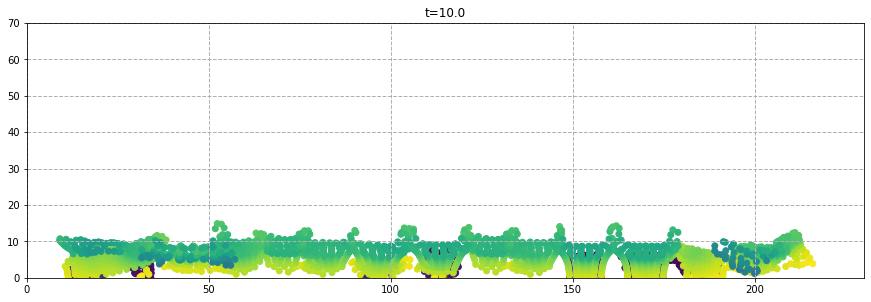

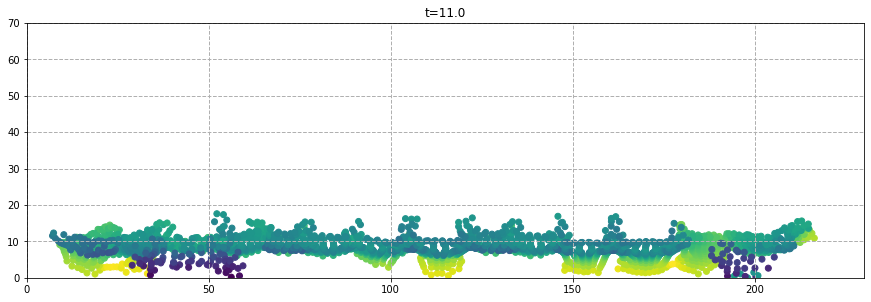

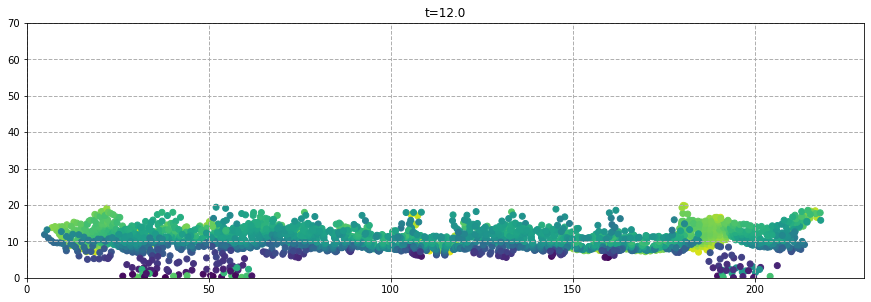

In [57]:
plot_all('v',index=1)

In [58]:
result.result_dir

'/tmp/spatialpy_result_r4do8tca'

TypeError: plot_property() got an unexpected keyword argument 'animate'